# Prepare

In [ ]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.12.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:


import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal


data = pd.read_excel('4A_TB_cleaned.xlsx')

data.shape

data = pd.concat([data] * 4, ignore_index=True)

data.shape

data.head()

data['SEX'].value_counts()

# Converting duration to whole weeks (assuming 7 days per week)
data['Duration (weeks)'] = data['DURATION'].apply(lambda x: int(x // 7 + (x % 7 > 0)))
data['WEEK'] = [1, 2, 3, 4] * (len(data) // 4)

data.head()

# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1 if row['WEEK'] >= row['Duration (weeks)'] else 0
    else:
        return 0 if row['WEEK'] <= row['Duration (weeks)'] else None


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)



data.head()

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME', 'Duration (weeks)'], inplace=True)



new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL', 'WEEK']
data = data[new_col_order]

data.head()

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.head()

data.shape

<ipython-input-2-4671fe130f54>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['SURVIVAL'], inplace=True)
<ipython-input-2-4671fe130f54>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SURVIVAL'] = data['SURVIVAL'].astype(int)


(39064, 13)

In [ ]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL,WEEK
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0,1
1,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0,1
2,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,0,1
3,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,0,2
4,M,22,CATHOLIC,CENTRAL,0,Abdominal_TB,8,Monday,December,2010,9,0,1


In [ ]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,WEEK,Month of Admission,Day of Admission,SEX_F,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.499157,-0.768999,0.671691,2010,-0.376849,0,1,1.316377,-0.363370,0,...,0,0,0,0,1,0,0,0,0,0
1,0.973860,-0.768999,0.263214,2010,-0.588397,0,1,1.607375,-0.409039,1,...,0,0,0,0,0,0,1,0,0,0
2,4.104020,0.514769,1.080168,2010,-0.165300,0,1,1.607375,-0.317701,0,...,0,0,0,0,1,0,0,0,0,0
3,4.104020,0.514769,1.080168,2010,-0.165300,0,2,1.607375,-0.317701,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.235665,-2.052767,1.284406,2010,-0.059526,0,1,1.607375,-0.409039,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# **data splitting**

dataset['YEAR OF ADMISSION'].value_counts()



# prompt: create two data frames one for testing and the other for training and validation. dataset is split into these two using the 'YEAR OF ADMISSION' column.2018 and above go  to test dataset, 2017 and 2016 go validation dataset. then below 2016 goes to training dataset. use the copy method because i will have to standardize. Lets add the part of dropping that column from our data frames

test_data = dataset[dataset['YEAR OF ADMISSION'] >= 2018].copy()
train_data = dataset[dataset['YEAR OF ADMISSION'] < 2018].copy()

test_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
train_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
dataset.drop(columns=['YEAR OF ADMISSION'], inplace=True)


def to_tf_dataset(data, features, target, task_col, batch_size=64):
    def generator():
        for _, row in data.iterrows():
            x = row[features].values.astype(np.float32)
            y = row[target].astype(np.float32)
            task = row[task_col].astype(np.int32) - 1
            yield x, y, task

    output_signature = (
        tf.TensorSpec(shape=(len(features),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).batch(batch_size).shuffle(buffer_size=1024)

X = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E = 'SURVIVAL'
T = 'DURATION'

train_dataset = to_tf_dataset(train_data, X, E, T)
test_dataset = to_tf_dataset(test_data, X, E, T)

In [ ]:
train_data.shape

(31336, 26)

# train 1

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'])(x)
        outputs = Dense(self.num_times + 1, activation='linear')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-6, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        # Adjust Triangle shape to match y_pred
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1) # Fix: Adjust Triangle1 shape
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk


# Example usage
structure = [{'activation': 'relu', 'num_units': 128}]
model = BaseMultiTaskModel(structure=structure, bins=100)


X_data = dataset[X].values
T_data = dataset[T].values
E_data = dataset[E].values

# Fit the model
model.fit(X_data, T_data, E_data, epochs=100, verbose=True)
hazard, density, Survival = model.predict(X_data[:5])
print(hazard, density, Survival)


Epoch 1/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 110.8605
Epoch 2/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 83.3100
Epoch 3/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 61.5139
Epoch 4/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 47.8118
Epoch 5/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 39.5568
Epoch 6/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 35.0787
Epoch 7/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 32.5627
Epoch 8/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.9572
Epoch 9/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 29.5951
Epoch 10/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 28.4321
Epoch 11/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.5782
Epoch 12/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.0328
Epoch 13/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 26.5624
Epoch 14/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 26.1443


KeyboardInterrupt: 

# Trainin

Epoch 1/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 95.7172
Epoch 2/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 84.3350
Epoch 3/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 73.5696
Epoch 4/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 65.7456
Epoch 5/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 59.8053
Epoch 6/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 54.1616
Epoch 7/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 50.4692
Epoch 8/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 46.8422
Epoch 9/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 43.8252
Epoch 10/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 41.1758
Epoch 11/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 39.3419
Epoch 12/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 37.3404
Epoch 13/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.7721
Epoch 14/1000
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - l

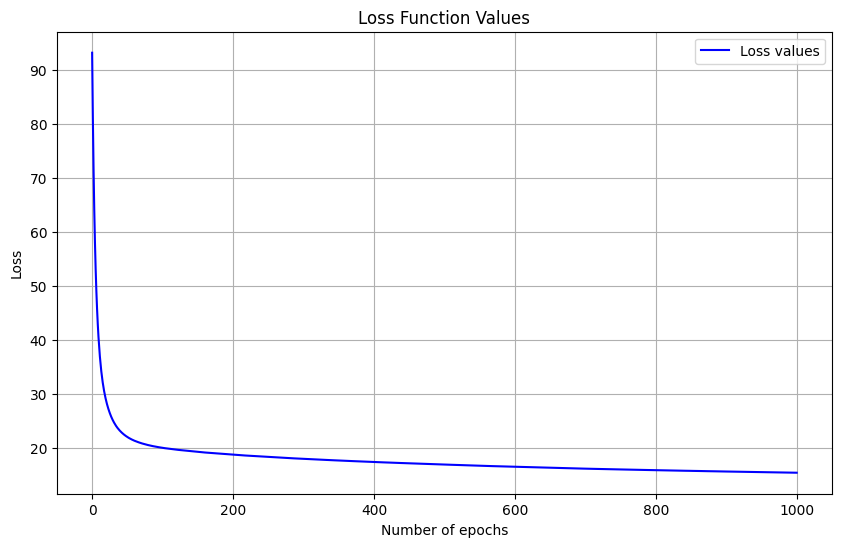

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[1.83022931e+00 7.75025389e-01 7.05401213e-01 4.35523958e-01
  9.79159974e-01 9.72235181e-01 3.90876281e-01 5.24449682e-01
  1.56657929e-01 6.10628347e-02 6.88440508e-02 3.99347209e-02
  2.23621704e-02 2.05980206e-02 2.99506507e-02 2.31409519e-02
  5.29379860e-03 6.96661937e-03 7.37688510e-03 1.26510681e-02
  7.20615827e-03 9.86537103e-03 2.34622287e-02 6.39580007e-02
  1.08164542e-01 4.55100217e-02 5.21576902e-02 6.42493525e-02
  5.27810420e-02 1.14417567e-01 4.70802753e-02 3.81473496e-02
  5.95072819e-02 4.34591845e-02 4.29318238e-02 2.88068787e-02
  8.35680268e-02 8.82343853e-02 8.38655696e-02 4.60494610e-02
  4.17101996e-02 2.84533235e-02 1.09443776e-02 5.67552699e-03
  3.09589470e-03 3.69753966e-03 3.19229399e-03 2.44785642e-03
  6.51575458e-04 7.40709542e-04 9.09091144e-04 2.61879656e-03
  4.60415764e-03 3.45329052e-03 2.05729385e-03 1.51756110e-03
  7.71265700e-04 4.40024021e-04 1.78950279e-04 1.82079681e-04
  1.56751033e-04 3.51214968e-04 

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'])(x)
        outputs = Dense(self.num_times + 1, activation='linear')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-6, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        # Adjust Triangle shape to match y_pred
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        # Store the loss values
        self.loss_values = history.history['loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1) # Fix: Adjust Triangle1 shape
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Loss values', color='blue')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
structure = [{'activation': 'tanh', 'num_units': 128}, {'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Assuming dataset is a DataFrame and 'X', 'T', 'E' are the column names for features, times, and events respectively
X_data = dataset[X].values
T_data = dataset[T].values
E_data = dataset[E].values

# Fit the model
model.fit(X_data, T_data, E_data, epochs=1000, verbose=True)

# Plot the loss curve
model.plot_loss_curve()

# Make predictions (example)
hazard, density, Survival = model.predict(X_data[:5])
print(hazard, density, Survival)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'])(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-6, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        # Adjust Triangle shape to match y_pred
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        # Split the data into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        # Store the loss values
        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1) # Fix: Adjust Triangle1 shape
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        # Compute survival predictions
        _, _, Survival = self.predict(X)

        # Compute c-index
        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E == 1, T, 1 - Survival[:, -1])[0]

        # Compute Brier score
        brier_score = np.mean((1 - Survival[:, -1] - E) ** 2)

        return c_index, brier_score



In [ ]:
# Example usage
structure = [{'activation': 'tanh', 'num_units': 128},{'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Assuming dataset is a DataFrame and 'X', 'T', 'E' are the column names for features, times, and events respectively
X_data = dataset[X].values
T_data = dataset[T].values
E_data = dataset[E].values

# Fit the model
model.fit(X_data, T_data, E_data, epochs=100, verbose=True, validation_split=0.2)


Epoch 1/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 31.8000 - val_loss: 31.6559
Epoch 2/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31.2996 - val_loss: 31.5729
Epoch 3/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31.1373 - val_loss: 31.4893
Epoch 4/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.9424 - val_loss: 31.4061
Epoch 5/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 30.4566 - val_loss: 31.3233
Epoch 6/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.8026 - val_loss: 31.2409
Epoch 7/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.5679 - val_loss: 31.1586
Epoch 8/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 30.5703 - val_loss: 31.0771
Epoch 9/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 30.2528 - val_loss: 30.9958
Epoch 10/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 30.4872 - val_loss: 30.9151
Epoch 11/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.2019 - val_loss: 30.8348
Epoch 12/100
977/97

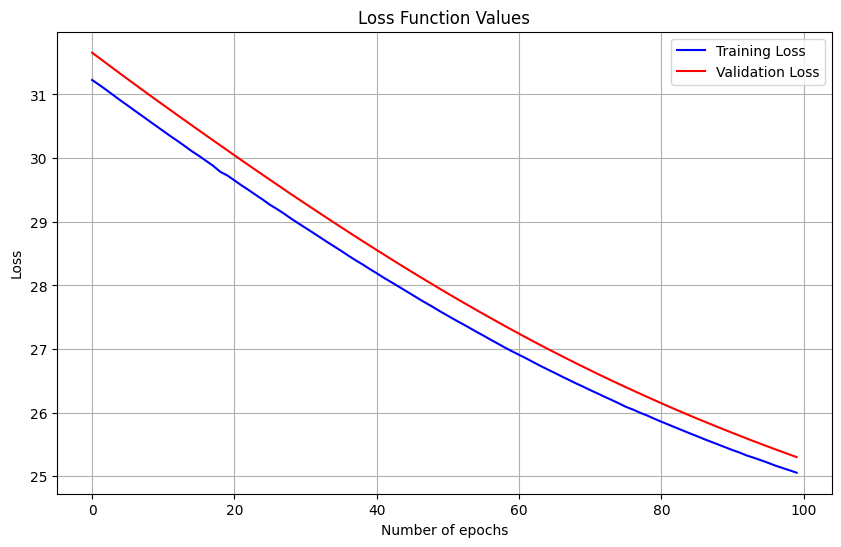

In [ ]:

# Plot the loss curve
model.plot_loss_curve()

In [ ]:

# Make predictions (example)
hazard, density, Survival = model.predict(X_data[:5])
print(hazard, density, Survival)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[0.3816351  0.24465067 0.19925663 0.18866399 0.21030698 0.23773421
  0.22571129 0.23173801 0.25228515 0.239615   0.25631475 0.29558898
  0.26567516 0.32621134 0.42896641 0.48941506 0.46108915 0.50623335
  0.57748417 0.60222533 0.53915036 0.57404725 0.58250075 0.56466001
  0.49286824 0.44817588 0.39586147 0.37446127 0.41874915 0.47003448
  0.54554092 0.50359067 0.42525164 0.46998335 0.44243933 0.48284958
  0.4704303  0.4571306  0.48908417 0.47218168 0.48958546 0.50564867
  0.4589184  0.64351099 0.57585851 0.44533889 0.49239681 0.51448369
  0.55038791 0.50112287 0.4874002  0.46004515 0.57307313 0.44398128
  0.55269842 0.54320503 0.53673046 0.54182129 0.58759174 0.59728953
  0.65141836 0.53667781 0.55817067 0.62030076 0.6377111  0.70708241
  0.65340235 0.62551384 0.59934396 0.53101513 0.4673468  0.50032335
  0.55343896 0.58004856 0.68460078 0.74138498 0.76499966 0.68527127
  0.64739342 0.68597186 0.92114681 0.74692121 0.580714   0.4686875
  0.5625867

In [ ]:
# Evaluate the model
X_test = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E_test = 'SURVIVAL'
T_test = 'DURATION'

test_dataset = to_tf_dataset(test_data, X_test, T_test, E_test)
c_index, brier_score = model.evaluate(X_data, T_data, E_data)
print(f"c-index: {c_index}, Brier score: {brier_score}")

1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
c-index: 0.5, Brier score: 0.5340978906409994


# training 2

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'])(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-6, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        # Adjust Triangle shape to match y_pred
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        # Split the data into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        # Store the loss values
        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1) # Fix: Adjust Triangle1 shape
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        # Compute survival predictions
        _, _, Survival = self.predict(X)

        # Compute c-index
        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E == 1, T, 1 - Survival[:, -1])[0]

        # Compute Brier score
        brier_score = self.compute_brier_score(X, T, E, Survival)

        return c_index, brier_score

    def compute_brier_score(self, X, T, E, Survival, t_max=None):
        if t_max is None:
            t_max = np.max(T)
        brier_scores = []
        times = np.linspace(0, t_max, self.bins)

        for t in times:
            observed_at_t = (T <= t).astype(int)
            survival_at_t = Survival[:, np.argmin(np.abs(self.times - t))]
            brier_scores.append(np.mean((observed_at_t - survival_at_t) ** 2))

        integrated_brier_score = np.trapz(brier_scores, times) / t_max
        self.plot_brier_score(times, brier_scores, integrated_brier_score)
        return integrated_brier_score

    def plot_brier_score(self, times, brier_scores, integrated_brier_score):
        plt.figure(figsize=(10, 6))
        plt.plot(times, brier_scores, label=f'IBS(t={times[-1]:.1f}) = {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()





In [ ]:
# Example usage
structure = [{'activation': 'relu', 'num_units': 32}, {'activation': 'tanh', 'num_units': 16}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Assuming dataset is a DataFrame and 'X', 'T', 'E' are the column names for features, times, and events respectively
X_data = dataset[X].values
T_data = dataset[T].values
E_data = dataset[E].values

# Fit the model
model.fit(X_data, T_data, E_data, epochs=10, verbose=True, validation_split=0.2)



Epoch 1/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 30.9548 - val_loss: 31.3844
Epoch 2/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 30.8456 - val_loss: 31.3518
Epoch 3/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 30.7987 - val_loss: 31.3193
Epoch 4/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.9027 - val_loss: 31.2869
Epoch 5/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 30.6373 - val_loss: 31.2543
Epoch 6/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31.1216 - val_loss: 31.2219
Epoch 7/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.7327 - val_loss: 31.1894
Epoch 8/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31.1496 - val_loss: 31.1571
Epoch 9/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.6434 - val_loss: 31.1247
Epoch 10/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 30.6353 - val_loss: 31.0925


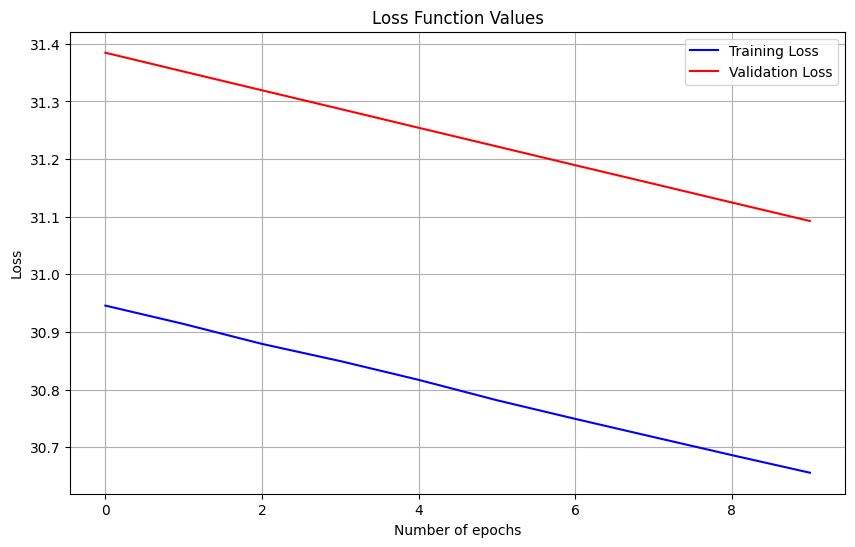

In [ ]:
# Plot the loss curve
model.plot_loss_curve()



In [ ]:
# Evaluate the model
c_index, brier_score = model.evaluate(X_data, T_data, E_data)
print(f"c-index: {c_index}, Brier score: {brier_score}")



TypeError: '_ShuffleDataset' object is not subscriptable

In [ ]:
# Make predictions (example)
hazard, density, Survival = model.predict(X_data[:5])
print(hazard, density, Survival)

# train

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'])(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-6, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        # Adjust Triangle shape to match y_pred
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=64, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        # Split the data into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        # Store the loss values
        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1) # Fix: Adjust Triangle1 shape
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        # Compute survival predictions
        _, _, Survival = self.predict(X)

        # Compute c-index
        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E == 1, T, 1 - Survival[:, -1])[0]

        # Compute Brier score
        brier_score = self.compute_brier_score(X, T, E, Survival)

        return c_index, brier_score

    def compute_brier_score(self, X, T, E, Survival, t_max=None):
        if t_max is None:
            t_max = np.max(T)
        brier_scores = []
        times = np.linspace(0, t_max, self.bins)

        for t in times:
            observed_at_t = (T <= t).astype(int)
            survival_at_t = Survival[:, np.argmin(np.abs(self.times - t))]
            brier_scores.append(np.mean((observed_at_t - survival_at_t) ** 2))

        integrated_brier_score = np.trapz(brier_scores, times) / t_max
        self.plot_brier_score(times, brier_scores, integrated_brier_score)
        return integrated_brier_score

    def plot_brier_score(self, times, brier_scores, integrated_brier_score):
        plt.figure(figsize=(10, 6))
        plt.plot(times, brier_scores, label=f'IBS(t={times[-1]:.1f}) = {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()




In [ ]:
# Example usage
structure = [{'activation': 'tanh', 'num_units': 16}, {'activation': 'relu', 'num_units': 8}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model
model.fit(train_data[X], train_data[T], train_data[E], epochs=100, batch_size=32, verbose=True, validation_split=0.2)



Epoch 1/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 55.4030 - val_loss: 53.6429
Epoch 2/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 54.8759 - val_loss: 53.6062
Epoch 3/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 54.4178 - val_loss: 53.5699
Epoch 4/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 54.5028 - val_loss: 53.5332
Epoch 5/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 54.1052 - val_loss: 53.4966
Epoch 6/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 54.2130 - val_loss: 53.4598
Epoch 7/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 53.7201 - val_loss: 53.4229
Epoch 8/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 54.2285 - val_loss: 53.3864
Epoch 9/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 55.3334 - val_loss: 53.3496
Epoch 10/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 54.7381 - val_loss: 53.3128
Epoch 11/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 54.4678 - val_loss: 53.2756
Epoch 12/100
784/78

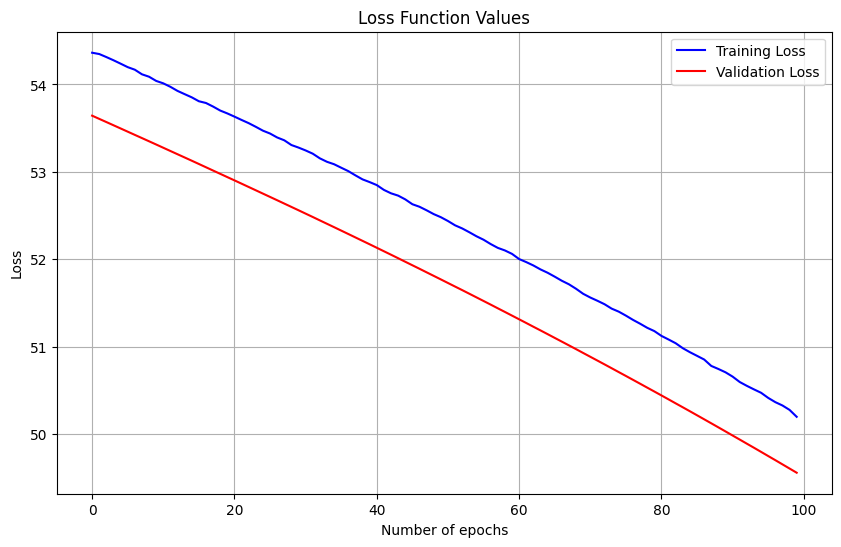

In [ ]:
# Plot the loss curve
model.plot_loss_curve()

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


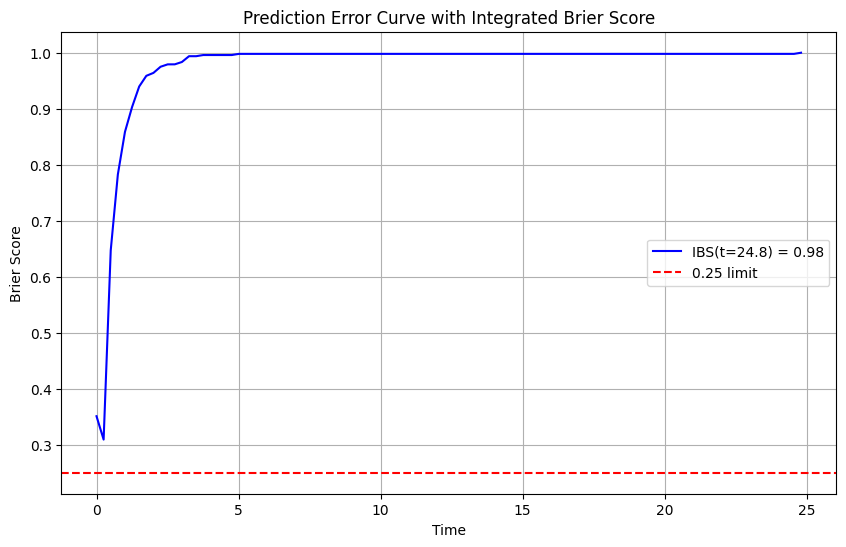

c-index: 0.5, Brier score: 0.9773630720314875


In [ ]:
# Evaluate the model
c_index, brier_score = model.evaluate(test_data[X], test_data[T], test_data[E])
print(f"c-index: {c_index}, Brier score: {brier_score}")



In [ ]:
# Make predictions (example)
hazard, density, Survival = model.predict(test_data[X].values[:5])
print(hazard, density, Survival)



# train5

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.5, l2_lambda=0.01):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda))(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        _, _, Survival = self.predict(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        return c_index, integrated_brier_score



In [ ]:
# Data preparation code remains the same
# Example usage
structure = [{'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model
model.fit(train_data[X], train_data[T], train_data[E], epochs=1000, batch_size=32, verbose=True, validation_split=0.2)




Epoch 1/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 51.8105 - val_loss: 40.8569
Epoch 2/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 40.2604 - val_loss: 33.0906
Epoch 3/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 33.5532 - val_loss: 29.7523
Epoch 4/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 30.6216 - val_loss: 28.1958
Epoch 5/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29.5691 - val_loss: 27.3091
Epoch 6/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 28.3115 - val_loss: 26.7256
Epoch 7/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.8240 - val_loss: 26.3372
Epoch 8/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.2992 - val_loss: 26.0639
Epoch 9/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 27.4249 - val_loss: 25.8586
Epoch 10/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.0371 - val_loss: 25.6799
Epoch 11/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 26.8297 - val_loss: 25.5555
Epoch 12

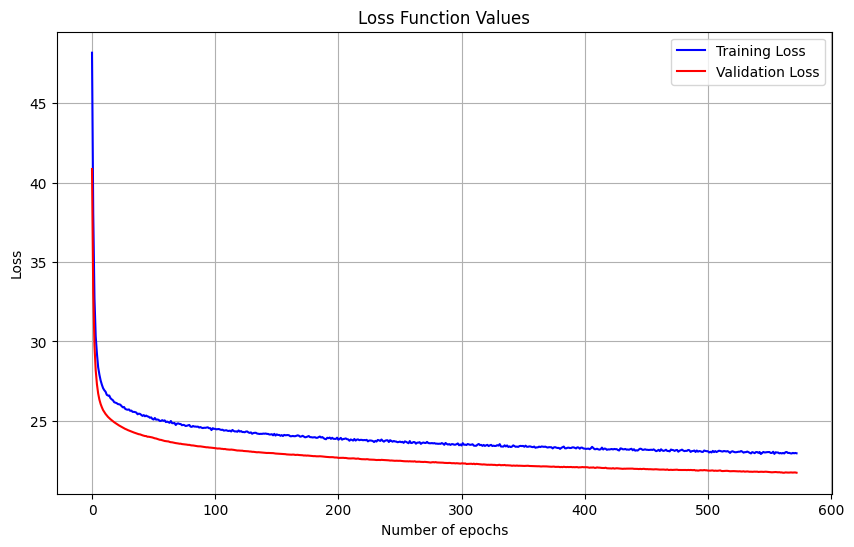

In [ ]:
# Plot the loss curve
model.plot_loss_curve()

In [ ]:
# Evaluate the model
c_index, brier_score = model.evaluate(test_data[X], test_data[T], test_data['SURVIVAL'] == 1) # Access the 'SURVIVAL' column and create a boolean array
print(f"c-index: {c_index}, Brier score: {brier_score}")

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
c-index: 0.5922738001573564, Brier score: 0.45193110651936935


In [ ]:
# Make predictions (example)
hazard, density, Survival = model.predict(test_data[X].values[:5])
print(hazard, density, Survival)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.58969093 0.27703347 0.11348172 0.04359024 0.0321334  0.02639099
  0.02112163 0.02094217 0.01630322 0.01637301 0.01561996 0.01568064
  0.01564111 0.01584951 0.01596911 0.01571833 0.0156153  0.01563661
  0.01585193 0.01606219 0.01607455 0.01631118 0.01656269 0.01669156
  0.01690745 0.01719392 0.0174513  0.01774781 0.01790902 0.01809043
  0.01839476 0.01869124 0.01901584 0.01936709 0.01969985 0.02003207
  0.02038187 0.02065389 0.02089496 0.02127124 0.02171549 0.0219827
  0.02168483 0.02209224 0.02247141 0.02285512 0.0233094  0.02381754
  0.02422498 0.02468505 0.02522025 0.02582157 0.02598731 0.02590788
  0.02546987 0.02582465 0.02641575 0.02708934 0.02706174 0.02741292
  0.0280758  0.02864498 0.02943462 0.02996142 0.03070924 0.03149719
  0.03247671 0.03332466 0.0342185  0.03534588 0.03661933 0.03764007
  0.03891792 0.04038855 0.04157379 0.04321113 0.04474437 0.04667041
  0.04891554 0.0512735  0.05370725 0.05665315 0.05997477 0.06349906
  0.0676256